In [1]:
!pip install -e ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2

Obtaining file:///home/nannau/03132020
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
  Running setup.py develop for climpyrical
You are using pip version 18.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load ensemble data for SL50 (kPa)

In [2]:
# PATH_MASK = '../../climpyrical/tests/data/'
# PATH = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
# PATH_MEAN = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
PATH = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'
PATH_MEAN = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc'
# print(xr.open_dataset(PATH))
dv = 'heating_degree_days_per_time_period'
# dv = 'snw'

dsold = read_data(PATH, dv)
ds_mean = read_data(PATH_MEAN, dv, ['rlon', 'rlat'])

N = 3
ds = regrid_ensemble(dsold, dv, N)
if 'time' in ds_mean.keys():
    ds_mean = regrid_ensemble(ds_mean.squeeze('time'), dv, N, ['rlon', 'rlat'])
else:
    ds_mean = regrid_ensemble(ds_mean, dv, N, ['rlon', 'rlat'])
mean = ds_mean[dv].values
    
    
dvmask = 'sftlf'
mask = read_data('/home/nannau/climdash/assets/data/land_mask_CanRCM4_sftlf.nc', dvmask, keys=['rlat', 'rlon'])
if 'time' in mask.keys():
    mask = mask.squeeze('time')
    mask = mask.drop('time')
mask = regrid_ensemble(mask, dvmask, N, ['rlon', 'rlat'])
mask = mask[dvmask].values >= 1.0
mask.shape, ds[dv].shape, ds_mean[dv].shape, mean.shape
ds_mean
assert mean.shape == ds[dv].values[0, ...].shape

# Mask the NaN values
create another boolean numpy array to mask thes values

In [494]:
final_mask = np.logical_and(mask.copy(), ~np.isnan(mean))
assert final_mask.shape == mean.shape

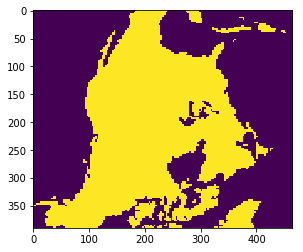

In [495]:
plt.imshow(final_mask)

In [589]:
# rotate_shapefile(canada)

# Create grids of rotated lon and lat
to make the final_mask play nicely with the coordinates and masking

In [496]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
assert rlon.shape == rlat.shape and rlon.shape == final_mask.shape

# Load Station Data and Process
Load the station data and find the corresponding grid cells in the models that we want to regress with. Then aggregate stations that fall within the same grid cell.

In [586]:
df_path = '../../climpyrical/tests/data/Interim_hdd_Tmax_Tmin_delivered.csv'
# df_path = '../../climpyrical/tests/data/sl50_short.csv'
df = pd.read_csv(df_path, index_col=None)
station_dv = 'HDD (degC-day)'
# station_dv = 'SL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

target = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values, target=target)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

df.to_csv('/home/nannau/climdash/assets/data/snow_stations.csv')

# find nearest grid cells to station locations in rlon and rlat using haversine distance
nearest_gridcell_idx = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy()[final_mask], rlat.copy()[final_mask]]).T), 
    metric='haversine'
)[0]

# create a mesh of indices of rlon and rlat grids for masking 
irlon, irlat = np.meshgrid(range(ds.rlon.size), range(ds.rlat.size))
# combine indices and extract the nearest grid cell index in x and y axis
ix_non_agg, iy_non_agg = np.stack([irlon[final_mask], irlat[final_mask]])[:, nearest_gridcell_idx]

# add to dataframe
matched_df = pd.DataFrame({'ilocy': iy_non_agg, 'ilocx': ix_non_agg, station_dv: df[station_dv], 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
# aggregate stations in same grid cell by taking mean
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})#, 'niy': 'min', 'nix': 'min'})


iy = matched_df.ilocy.values
ix = matched_df.ilocx.values

station_vals = matched_df[station_dv].values

matched_df['rlon'] = rlon[iy, ix]
matched_df['rlat'] = rlat[iy, ix]

matched_df.head()

TypeError: transform_coords() got an unexpected keyword argument 'target'

In [498]:
def regionalize(array):
    return array[u:lw, l:r].reshape((lw-u, r-l))
oldmean = mean.copy()
meanc = mean.copy()
tol = np.linspace(0.01, 50, 100000)

print(np.mean(matched_df[station_dv] - meanc[iy, ix]))
# oldmean[iy, ix][:10], mean[iy, ix][:10], station_vals[:10]
if np.mean(matched_df[station_dv] - meanc[iy, ix]) >= 0:
    print("THERE")
    rmtols = np.array([np.mean(matched_df[station_dv] - (meanc[iy, ix]/t)) for t in tol])
    print((np.diff(np.sign(rmtols))))
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0]]
    print(best_tol)
    mean = meanc/best_tol

if np.mean(matched_df[station_dv] - meanc[iy, ix]) < 0:
    print("HERE)")
    rmtols = np.array([np.mean(matched_df[station_dv] - (meanc[iy, ix]/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0]]
    print(best_tol)
    mean = meanc/best_tol

# np.mean(dfc[station_dv] - mean[iy, ix])
print(np.mean(matched_df[station_dv] - meanc[iy, ix]))

55.126725361960595
THERE
[0. 0. 0. ... 0. 0. 0.]
[0.98931389]
55.126725361960595


In [499]:
oldmean[iy, ix][:10], mean[iy, ix][:10], station_vals[:10]

(array([3189.793 , 3012.8398, 3012.8398, 3012.8398, 3012.8398, 3140.1575,
        3140.1575, 3140.1575, 3140.1575, 3281.3103], dtype=float32),
 array([3224.2476234 , 3045.38313335, 3045.38313335, 3045.38313335,
        3045.38313335, 3174.07598587, 3174.07598587, 3174.07598587,
        3174.07598587, 3316.75348491]),
 array([3362., 3556., 3461., 3272., 3399., 3442., 3590., 3768., 3652.,
        3578.]))

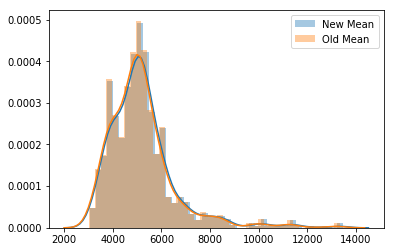

In [500]:
# plt.imshow(mean)
sns.distplot(mean[iy, ix], label='New Mean')
sns.distplot(oldmean[iy, ix], label='Old Mean')

# sns.distplot(dfc[station_dv] - meanc[dfc.ilocy, dfc.ilocx])
# sns.distplot((dfc[station_dv] - meanc[dfc.ilocy, dfc.ilocx] - best_tol))
# sns.distplot((matched_df[station_dv] - mean[iy, ix] - best_tol), label='Zero\'d Bias')
# sns.distplot((matched_df[station_dv] - mean[iy, ix]), label='Bias')
plt.legend()
plt.savefig('mean_distibution')
# sns.distplot()
# np.mean(np.mean(dfc[station_dv] - meanc[dfc.ilocy, dfc.ilocx] - best_tol))

In [501]:
# ensure that the stations are reasonably close to their nearest grid cell (within 0.6 degrees)
# and allow for some exceptions
assert np.sum(~np.isclose(rlon[iy_non_agg, ix_non_agg], df.rlon, atol=0.6)) < 6

# Stack the coordinates of the grid cells containing stations
do this for the training subset and the the full subset to that features (predictors) can be created 

In [502]:
# subset of grid cells closest station locations
X = np.stack([rlon[iy, ix], rlat[iy, ix]]).T

# full set of locations we wish to predict a value at
Xf = np.stack([rlon[final_mask], rlat[final_mask]]).T

In [503]:
q = np.array([np.var([station_vals[i], mean[iy, ix][i]]) for i in range(station_vals.size)])

In [504]:
from sklearn.metrics import r2_score

# custom distance metric
def dist(d):
    print(d.shape, q.shape)
    w = q
#     w = (d+d**-0.1/d)/2
    return w#[np.var([station_vals[i], mean[iy, ix][i]]) for i in range(station_vals.size)]

# Train a K Neighbors Regressor on the Station Subset
Once a model is trained, use it as an interpolator to find the rest of the 
land values
$$s \mapsto S$$

Use 5-fold cross validation to estimate the best $k$. 

In [505]:
weights = 'uniform'
# weights='distance'

warnings.filterwarnings("ignore")
model_s = KNeighborsRegressor()#weights='distance')
parameters = {'n_neighbors': range(2, 50), 'weights': ['uniform', 'distance']}

clf = GridSearchCV(model_s, parameters, cv=5)

clf.fit(X, station_vals)
k = clf.best_params_['n_neighbors']
weighting = clf.best_params_['weights']
"Best nearest neighbor number:", k, "Best weighting scheme:", weighting, 

('Best nearest neighbor number:', 4, 'Best weighting scheme:', 'distance')

# Compute S, the full reconstruction from stations only

(220.6911774004107, 220.6911774004107)

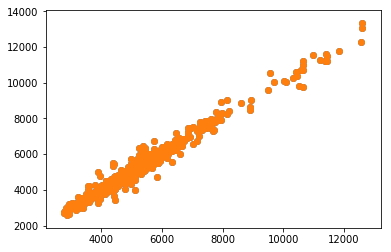

In [506]:
model_s = KNeighborsRegressor(weights=weights, n_neighbors=k).fit(X, station_vals)
def make_S(mean, model):
    S = mean.copy()
    S[final_mask] = model.predict(Xf)
    # Check for nan
#     assert(np.all(~np.isnan(S[final_mask])))
    # check that its behaving as perfect interpolation
#     assert(np.allclose(S[iy, ix], station_vals))
#     print(model.score(model.predict(X), station_vals))
    return S
S = make_S(mean, model_s)
# print(model_s.score(X, station_vals))
# model_s.predict(Xf)
plt.scatter(S[iy, ix], station_vals)
plt.scatter(model_s.predict(X), station_vals)
np.sqrt(mean_squared_error(S[iy, ix], station_vals)), np.sqrt(mean_squared_error(model_s.predict(X), station_vals))#, r2_score()

# Get corresponding ratios between station values and their nearest model value 

In [507]:
ratio = station_vals/mean[iy, ix] #np.var(station_vals, mean[iy, ix])

def undo(x, mean):
    return x*mean

def undo_rho(x, mean, rho):
    return ((np.ones(x.shape)-rho)+x)*mean

assert np.any(~np.isnan(ratio))

# Train a K Neighbors Regressor on the Station/Model Ratio Subset
Once a model is trained, use it as an interpolator to find the rest of the 
land values
$$s/\mu \mapsto B$$

Use 5-fold cross validation to estimate the best $k$. 

In [508]:
warnings.filterwarnings("ignore")
model_b = KNeighborsRegressor(weights=weights)

parameters = {'n_neighbors': range(2, 50)}
clf = GridSearchCV(model_b, parameters, cv=5)

clf.fit(X, ratio)
k_b = clf.best_params_['n_neighbors']
"Best nearest neighbor number:", k_b

('Best nearest neighbor number:', 37)

# Compute B, the full reconstruction from station bias only

0.8942926523742287


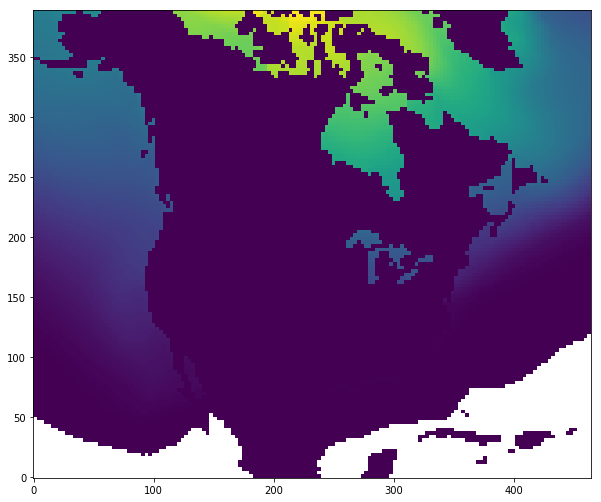

In [509]:
model_b = KNeighborsRegressor(weights=weights, n_neighbors=k_b).fit(X, ratio)
def make_B(mean, model):
    B = mean.copy()
    B[final_mask] = model_b.predict(Xf)
    # Check for nan
#     assert(np.all(~np.isnan(B[final_mask])))
    # check that its behaving as perfect interpolation
#     assert(np.allclose(B[iy, ix], ratio))
    return B
B = make_B(mean, model_b)
# B[iy, ix] = ratio
plt.figure(figsize=(10,10))
plt.imshow(B, origin='lower')
print(model_b.score(X, ratio))

In [510]:
# np.sqrt(mean_squared_error(S[iy, ix], station_vals)), np.sqrt(mean_squared_error(model_s.predict(X), station_vals)), np.sqrt(mean_squared_error)

# Define the softmax density field

In [511]:
import time
from scipy.spatial import distance
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
d_gridx = np.dstack((rlon, rlat))
a = np.array([rlon[final_mask], rlat[final_mask]]).T

d = model_b.kneighbors_graph(a, mode='distance').toarray()

a = np.array([rlon[final_mask], rlat[final_mask]]).T
a1 = np.array([rlon[iy, ix], rlat[iy, ix]]).T

full_dist = distance.cdist(a, a1)

from sklearn.metrics import pairwise_distances_argmin_min
full_dist_i, full_dist = pairwise_distances_argmin_min(a, a1, metric='euclidean')
full_dist.shape

np.amin(distance.cdist(a, a1, metric='euclidean'), axis=1)

array([29.83720594, 29.75165077, 29.66657397, ..., 11.06920548,
       11.19384849, 11.31901941])

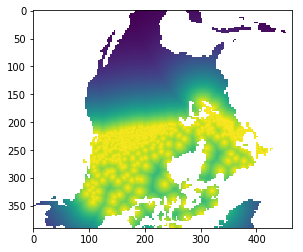

In [512]:
# pwhole = mean.copy()
# pwhole[~final_mask] = np.nan

def pwhole_def(alpha, i):
#     s=time.time()
    c = mean.copy()
    d = np.amin(distance.cdist(a, a1[i], metric='euclidean'), axis=1)
#     d = pairwise_distances_argmin_min(a, a1[i], metric='euclidean')[1]
    c[final_mask] = np.exp(-alpha*d)
    c[~final_mask] = np.nan
#     print("Time:", time.time()-s)
    return c

def get_pwhole(split):
#     s=time.time()
    p = np.array([pairwise_distances_argmin_min(a, a1[train], metric='euclidean')[1] for train in split])
#     print(time.time()-s)
    return p

def pwhole_model(p, alpha):
    return np.exp(-alpha*p)

plt.imshow(pwhole_def(0.11, range(station_vals.size)))
# loo = LeaveOneOut()
# trains = np.array([train for train, test in loo.split(X)])
# start = time.time()

# pwhole = np.ones((trains.shape[0], mean.shape[0], mean.shape[1]))
# pwhole[:, final_mask] = np.array([pwhole_model(get_pwhole(trains), alpha).reshape(mean.shape) for alpha in alphas])
# pwhole[:, ~final_mask] = np.nan

In [513]:
# sns.distplot(pwhole[0, final_mask])

In [514]:
# loo_val_ci_asd = pwhole[400, iy, ix]

In [515]:
# copy = mean.copy()
# copy[final_mask] = np.exp(-alpha*pairwise_distances_argmin_min(a, a1, metric='euclidean')[1])
# copy[~final_mask] = np.nan
# plt.imshow(copy)

In [516]:
# plt.imshow(pwhole[0, ...], origin='lower')

In [517]:
# assert(np.allclose(pwhole_model(1, range(station_vals.size-5))[final_mask], pwhole_model(1, range(station_vals.size-5))[final_mask]))

# Create the final reconcstructions
Note that we have many different possible reconstructions to use, so here are the simple reconstruction steps for each.

For the station only reconstruction (station interpolation using K-NN Regression)
$$R_{s} = S$$

For the station bias only reconstruction
$$R_b = B\mu$$

Where $\mu$ is the ensemble mean.

For the weighted bias reconstruction
$$R_b(\rho) = \left((1-\rho)+B\right)\mu $$

In [570]:
R_s = S.copy()
R_b = undo(B, mean)
rho = pwhole_def(.11, range(station_vals.size))
R_s_rho = (np.ones(mean.shape)-rho)*mean+S*rho

R_b_rho = undo_rho(B, mean, rho)#((np.ones(mean.shape)-rho)+B)*mean

assert(R_s.shape == R_b.shape and R_b_rho.shape == R_s.shape, np.sum(rho == 1.0) == station_vals.size)

In [571]:
np.sqrt(mean_squared_error(R_b[iy, ix], station_vals))

324.0206323417559

In [572]:
np.sum(rho==1.0)

1122

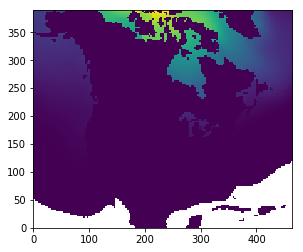

In [573]:
plt.imshow(R_b, origin='lower')#, vmin=0, vmax=1)

# Leave One Out Cross Validation

Perform LOO CV on both station-only reconstructions, $S$ and $B$. From the LOO CV, we get a predicted value for each station location and we can use that further on to compare to the expected values.

In [574]:
# from shapely.geometry import Point, Polygon
# lon1, lon2 = -90, -50
# lat1, lat2 =40, 60

# dfc = matched_df.copy()

# region_cond = ((dfc.lon > lon1) & (dfc.lon < lon2) & (dfc.lat > lat1) & (dfc.lat < lat2))
# region_cond_df = ((df.lon > lon1) & (df.lon < lon2) & (df.lat > lat1) & (df.lat < lat2))

# iy, ix = dfc.ilocy.values[region_cond], dfc.ilocx.values[region_cond]

In [575]:
# %%time

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

loo = LeaveOneOut()
# # loo = KFold(n_splits=15)
# array_of_ps = np.array([np.exp(np.multiply(-alpha, np.amin(full_dist[:, i], axis=1))) for i in range(station_vals.size)])
# array_of_ps
# pwhole.shape

In [576]:
# %%time

def looit(train_index, test_index, X, Y, k):
    model = KNeighborsRegressor(n_neighbors=k, weights=weights)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model.fit(X_train, y_train)
    return model.predict(X_test)[0]

pwhole = mean.copy()
pwhole[~final_mask] = np.nan

def rho_split(pwhole, train_index, test_index, alpha):
#     pwhole = pwhole_def(alpha, train_index)
    return pwhole_def(alpha, train_index)[iy, ix][test_index]

loo_s = np.array([looit(train_index, test_index, X, station_vals, k) for train_index, test_index in loo.split(station_vals)])
print("Done 1")
loo_b = np.array([looit(train_index, test_index, X, ratio, k_b) for train_index, test_index in loo.split(ratio)])
print("Done 2")

alphas = np.linspace(1, 0.08, 10)

start = time.time()
loo_rho_val = np.array([np.array([rho_split(pwhole_def, train_index, test_index, alpha) for train_index, test_index in loo.split(ratio)]) for alpha in alphas])
print((time.time()-start)/60.)

Done 1
Done 2


KeyboardInterrupt: 

In [577]:
# loo_rho_val

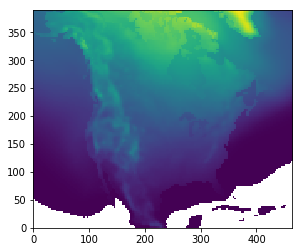

In [578]:
plt.imshow(mean, origin='lower')

In [579]:
loo_b_rho_a = []
loo_s_rho_a = []

for i, alpha in enumerate(alphas):
    rho_val_cv = np.array(loo_rho_val)[i, :].flatten()
    loo_s_rho = (np.ones(rho_val_cv.shape)-rho_val_cv)*mean[iy, ix]+rho_val_cv*loo_s
    loo_b_rho = undo_rho(loo_b, mean[iy, ix], rho_val_cv) #((np.ones(rho_val_cv.shape)-rho_val_cv*mean[iy, ix])+(np.sqrt(loo_b*loo_b.size) + mean[iy, ix]))#*mean[iy, ix] ###

    loo_s_rho_a.append(np.sqrt(mean_squared_error(loo_s_rho, S[iy, ix])))
    loo_b_rho_a.append(np.sqrt(mean_squared_error(loo_b_rho, S[iy, ix])))

rho_val_cv_i = np.array(loo_rho_val)[np.argmin(loo_s_rho_a), :][:, 0]

ValueError: operands could not be broadcast together with shapes (449,) (1122,) 

In [ ]:
plt.plot(alphas, loo_s_rho_a)
# plt.plot(alphas, loo_b_rho_a)
# mina = alphas[np.argmin(loo_s_rho_a)]
mina=0.111

R_s = S.copy()
R_b = undo(B, mean)

rho = pwhole_def(mina, range(station_vals.size))
R_s_rho = (np.ones(mean.shape)-rho)*S+mean

# R_b_rho = ((np.ones(mean.shape)-rho)+B)*mean
R_b_rho = undo_rho(B, mean, rho)#((np.ones(mean.shape)-rho*mean)+(np.sqrt(B*station_vals.size) + mean))

assert(R_s.shape == R_b.shape and R_b_rho.shape == R_s.shape)
print(mina)

In [580]:
np.sqrt(mean_squared_error(R_b[iy, ix], station_vals))

324.0206323417559

In [581]:
# rho_val_cv = loo_rho_val[:, 0]
loo_s_rho = (np.ones(rho_val_cv_i.shape)-rho_val_cv_i)*mean[iy, ix]+rho_val_cv_i*loo_s
loo_b_rho = undo_rho(loo_b, mean[iy, ix], rho_val_cv_i)#((np.ones(rho_val_cv_i.shape)-rho_val_cv_i)*mean[iy, ix]+(np.sqrt(loo_b*loo_b.size)+mean[iy, ix]))
loo_b_post = loo_b*mean[iy, ix]

ValueError: operands could not be broadcast together with shapes (449,) (1122,) 

In [582]:
loo_s.shape, loo_b.shape, loo_s_rho.shape, loo_b_rho.shape, ratio.shape, mean[iy, ix].shape, rho[iy, ix].shape

((1122,), (1122,), (449,), (449,), (1122,), (1122,), (1122,))

# Create a sub region defining some location
* Copy the dataframe and filter it using lat/lon boundaries
* Using the corresponding rlon and rlat values in the dataframe, find the nearest index in the model axis that corresponds to the bounding value
* Use these bounding indices to create a sub mask that combines the land mask with the resulting region selection

In [583]:
from shapely.geometry import Point, Polygon
lon1, lon2 = -90, -50
lat1, lat2 = 40, 60

# lon1, lon2 = -140, -90
# lat1, lat2 = 48, 60

lon1, lon2 = -140, -100
lat1, lat2 = 55, 80

dfc = matched_df.copy()

region_cond = ((dfc.lon > lon1) & (dfc.lon < lon2) & (dfc.lat > lat1) & (dfc.lat < lat2))
region_cond_df = ((df.lon > lon1) & (df.lon < lon2) & (df.lat > lat1) & (df.lat < lat2))

# dfc = dfc[region_cond]
# ratio_region = dfc[station_dv].values/mean[iy, ix]
# dfc = dfc.assign(loo_s=loo_s, loo_b=loo_b, loo_s_rho=loo_s_rho, loo_b_rho=loo_b_rho, loo_b_post=loo_b_post, ratio=ratio, mean_dv=mean[iy, ix], rho=rho[iy, ix])
dfc = dfc[region_cond]


p1 = (dfc.rlon.min(), dfc.rlat.min())
p2 = (dfc.rlon.max(), dfc.rlat.min())
p3 = (dfc.rlon.max(), dfc.rlat.max())
p4 = (dfc.rlon.min(), dfc.rlat.max())

l, r = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())
u, lw = find_nearest_index(ds.rlat.values, dfc.rlat.min()), find_nearest_index(ds.rlat.values, dfc.rlat.max())

final_mask_c = final_mask.copy()
region = final_mask.copy() 
region[...] = False
region[u:lw, l:r] = True
# If True, keep station locations in the mask
final_mask_c[iy, ix] = True
# combine region mask and land mask
region = np.logical_and(final_mask_c, region)
region[dfc.ilocy, dfc.ilocx] = False

def regionalize(array):
    return array[u:lw, l:r].reshape((lw-u, r-l))

# check that the number of stations match Charles's
df[region_cond_df].shape[0], dfc.shape[0], matched_df.shape[0]
area_of_interest = Polygon([p1, p2, p3, p4])


$$E_m = (1-\rho_{i, j})(R_{i, j} - \mu_{i, j})$$
$$E_s = R_{I, J} - s$$
$$RMSE = \sqrt{\frac{\sum{E_m^2}}{M} + \frac{\sum{E_s^2}}{N}}$$

$I, J$ are indices containing $N$ stations

$i, j$ are all $M$ grid indices except $I, J$

$\rho_{i, j}$ is softmax density evaluated at $M$ grid indices

$\rho_{I, J} = 1$ 

$\mu$ is ensemble mean

$R$ is the reconstruction 

[338.32841959897047, 501.0432502099645, 329.8924024508788]


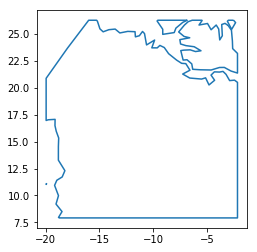

In [585]:
Reconstruction_arr = np.array([R_s.copy(), R_b.copy(), R_s_rho.copy()])
rmsescores = []
RMSE_mask = region.copy()
for Reconstruction in Reconstruction_arr:
    # RMSE_mask[dfc.ilocy, dfc.ilocx] = False
    # RSSME = mean.copy()

    b_M = (Reconstruction[RMSE_mask] - mean[RMSE_mask])
    E_M = (1-rho[RMSE_mask])*b_M
    E_S = (Reconstruction[dfc.ilocy, dfc.ilocx] - dfc[station_dv])
    rmsescores.append(np.sqrt(np.sum(E_M**2)/np.sum(RMSE_mask)+np.sum(E_S**2)/dfc[station_dv].size))

print(rmsescores)
    
import geopandas as gpd
canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)
canada = canada.intersection(area_of_interest).boundary
canada.plot()

In [219]:
latarr = '78.7833 76.2333 72.0000 70.1667 69.5833 69.4500 69.4333 69.1081 68.7500 68.3042 67.8333 67.8167 65.4833 65.2825 64.0500 64.0431 63.6167 62.7167 62.4628 62.2069 61.7603 61.3667 61.2419 61.1808 61.1333 60.8397 60.7725 60.7095 60.1741 60.1165 60.0203 59.5667 59.2500 58.8364 58.6214 58.4283 58.3833 58.0833 57.3500 57.2500 56.8639 56.6500 56.2381 56.2269 56.0667 55.9361 55.8333 55.7855 55.6872 55.3000 55.2375 55.2000 55.1797 55.1500'
latarr = np.array(latarr.split(' '), dtype=float)
# np.allclose(df[region_cond_df].lat.sort_values(ascending=False).values, latarr)
# df[region_cond_df].sort_values(by='lat', ascending=False).to_csv('/home/nannau/Desktop/northern_region_stations.csv')

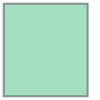

In [220]:
area_of_interest = Polygon([p1, p2, p3, p4])
area_of_interest

In [221]:
# meanc = mean.copy()
# tol = np.linspace(0, np.mean(meanc[iy, ix]), 100000)
# if np.mean(station_vals - meanc[iy, ix]) >= 0:
#     rmtols = np.array([np.mean(station_vals - meanc[iy, ix]-t) for t in tol])
#     best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]
#     mean = meanc-best_tol
# if np.mean(station_vals - meanc[iy, ix]) < 0:
#     rmtols = np.array([np.mean(station_vals - meanc[iy, ix]+t) for t in tol])
#     best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]
#     mean = mean+best_tol

# np.mean(station_vals - meanc[iy, ix] - best_tol)

In [222]:
# station_vals, S[iy, ix]#np.isnan(B[region]), 
# mean_a_error(R_b[region], mean[region])
print(np.sqrt(mean_squared_error(loo_b_post, mean[iy, ix])), np.sqrt(mean_squared_error(loo_s, mean[iy, ix])), np.sqrt(mean_squared_error(loo_s_rho, mean[iy, ix])))
print(np.sqrt(mean_squared_error(loo_b_post, S[iy, ix])), np.sqrt(mean_squared_error(loo_s, S[iy, ix])))

2.090201373738154 2.8316979979676935 2.725299094997328


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [250]:
def mean_a_error(x, y):
    return np.mean(x-y)

S = make_S(mean, model_s)
# S[iy, ix] = station_vals
B = make_B(mean, model_b)
# B[iy, ix] = ratio

R_s = S.copy()
R_b = undo(B, mean)

rho = pwhole_def(mina, range(station_vals.size))
R_s_rho = (np.ones(mean.shape)-rho)*mean+S*rho

# R_b_rho = ((np.ones(mean.shape)-rho)+B)*mean
R_b_rho = undo_rho(B, mean, rho)#((np.ones(mean.shape)-rho*mean)+(np.sqrt(B*station_vals.size) + mean))

assert(R_s.shape == R_b.shape and R_b_rho.shape == R_s.shape)
print(mina)

rmse = {
    'rmse_loo_s_S_at_stations': np.sqrt(mean_squared_error(dfc.loo_s, S[dfc.ilocy, dfc.ilocx])),
    'rmse_loo_b_B_at_stations': np.sqrt(mean_squared_error(dfc.loo_b, B[dfc.ilocy, dfc.ilocx])),
    'rmse_loo_b_post_at_stations': np.sqrt(mean_squared_error(dfc.loo_b_post, S[dfc.ilocy, dfc.ilocx])),
    'rmse_loo_s_rho_S_at_stations': np.sqrt(mean_squared_error(dfc.loo_s_rho, S[dfc.ilocy, dfc.ilocx])),
    'rmse_loo_b_rho_post_S_at_stations': np.sqrt(mean_squared_error(dfc.loo_b_rho, S[dfc.ilocy, dfc.ilocx])),
    'rmse_loo_b_rho_B_at_stations': np.sqrt(mean_squared_error(dfc.loo_b_rho, B[dfc.ilocy, dfc.ilocx])),
    'rmse_R_b_S_in_region': np.sqrt(mean_squared_error(S[region], R_b[region])),
    'rmse_R_b_rho_S_in_region': np.sqrt(mean_squared_error(S[region], R_b_rho[region])),
    'rmse_R_s_rho_S_in_region': np.sqrt(mean_squared_error(S[region], R_s_rho[region])),
    'rmse_R_b_model_in_region': np.sqrt(mean_squared_error(mean[region], R_b[region])),
    'rmse_R_b_rho_model_in_region': np.sqrt(mean_squared_error(mean[region], R_b_rho[region])),
    'mae_loo_s_S_at_stations': mean_a_error(dfc.loo_s, S[dfc.ilocy, dfc.ilocx]),
    'mae_loo_s_rho_S_at_stations': mean_a_error(dfc.loo_s_rho, S[dfc.ilocy, dfc.ilocx]),
    'mae_loo_b_B_at_stations': mean_a_error(dfc.loo_b, B[dfc.ilocy, dfc.ilocx]),
    'mae_R_b_S_in_region': mean_a_error(S[region], R_b[region]),
    'mae_R_b_rho_S_in_region': mean_a_error(S[region], R_b_rho[region]),
    'mae_R_s_rho_S_in_region': mean_a_error(S[region], R_s_rho[region]),
    'mae_R_b_model_in_region': mean_a_error(mean[region], R_b[region]),
    'mae_R_b_rho_model_in_region': mean_a_error(mean[region], R_b_rho[region]),
    'mae_loo_b_rho_post_S_at_stations': mean_a_error(dfc.loo_b_rho, S[dfc.ilocy, dfc.ilocx]),
    'mae_loo_b_post_at_stations': mean_a_error(dfc.loo_b_post, S[dfc.ilocy, dfc.ilocx]),
    'rmse_S_mod': np.sqrt(mean_squared_error(R_s[region], oldmean[region])),
    'rmse_R_b_mod': np.sqrt(mean_squared_error(R_b[region], oldmean[region])),
    'rmse_R_s_rho_mod': np.sqrt(mean_squared_error(R_s_rho[region], oldmean[region])),
    'rmse_R_b_rho_mod': np.sqrt(mean_squared_error(R_b_rho[region], oldmean[region])),

    'bias_S_mod': mean_a_error(R_s[region], oldmean[region]),
    'bias_R_b_mod': mean_a_error(R_b[region], oldmean[region]),
    'bias_R_s_rho_mod': mean_a_error(R_s_rho[region], oldmean[region]),
    'bias_R_b_rho_mod': mean_a_error(R_b_rho[region], oldmean[region]),
}

rmse

# np.sqrt(mean_squared_error(dfc[station_dv], S[dfc.ilocy, dfc.ilocx]))

0.111


{'rmse_loo_s_S_at_stations': 0.11023132254369186,
 'rmse_loo_b_B_at_stations': 0.06252271372706082,
 'rmse_loo_b_post_at_stations': 1.7032219383213556,
 'rmse_loo_s_rho_S_at_stations': 0.22687400680963357,
 'rmse_loo_b_rho_post_S_at_stations': 2.0090123416498917,
 'rmse_loo_b_rho_B_at_stations': 3.0668223750212262,
 'rmse_R_b_S_in_region': 1.4050842406229511,
 'rmse_R_b_rho_S_in_region': 1.9023643092141673,
 'rmse_R_s_rho_S_in_region': 0.3928879787789475,
 'rmse_R_b_model_in_region': 2.4549420329187615,
 'rmse_R_b_rho_model_in_region': 2.1138488145402117,
 'mae_loo_s_S_at_stations': -0.0009615384615384624,
 'mae_loo_s_rho_S_at_stations': 0.0798798599370458,
 'mae_loo_b_B_at_stations': 0.005778713500569848,
 'mae_R_b_S_in_region': -0.4325708340794118,
 'mae_R_b_rho_S_in_region': -0.9102621312462355,
 'mae_R_s_rho_S_in_region': -0.14278819100804235,
 'mae_R_b_model_in_region': 0.7527568198911004,
 'mae_R_b_rho_model_in_region': 0.2750655227242769,
 'mae_loo_b_rho_post_S_at_stations': 0.6

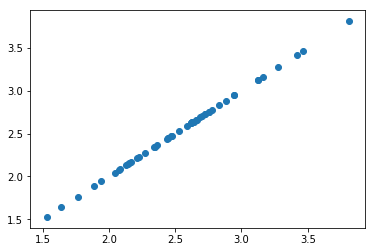

In [224]:
plt.scatter(S[dfc.ilocy, dfc.ilocx], R_s_rho[dfc.ilocy, dfc.ilocx])

In [225]:
print(np.mean(S[dfc.ilocy, dfc.ilocx]-dfc[station_dv]), ",", np.mean(R_b[dfc.ilocy, dfc.ilocx]-dfc[station_dv]),  ",", np.mean(R_s_rho[dfc.ilocy, dfc.ilocx]-dfc[station_dv]))
print(np.sqrt(mean_squared_error(S[dfc.ilocy, dfc.ilocx], dfc[station_dv])),  ",", np.sqrt(mean_squared_error(R_b[dfc.ilocy, dfc.ilocx], dfc[station_dv])), ",", np.sqrt(mean_squared_error(R_s_rho[dfc.ilocy, dfc.ilocx], dfc[station_dv])))
print(np.sqrt(mean_squared_error(S[region], oldmean[region])),  ",", np.sqrt(mean_squared_error(R_b[region], oldmean[region])), ",", np.sqrt(mean_squared_error(R_s_rho[region], oldmean[region])))

-0.07618343195266274 , 0.1530350117987095 , -0.07618343195266274
1.1143739044448238 , 0.93470673240686 , 1.1143739044448238
2.2778061887791674 , 1.4818525711650699 , 1.971942707184108


In [226]:
def pe(x, y):
    return 100*(x-y)/y
dfc = dfc.assign(
    SL50_p_error=pe(dfc.loo_s, dfc[station_dv]),
    ratio_p_error=pe(dfc.loo_b, dfc.ratio),
    post_ratio_p_error = pe(undo(dfc.loo_b, dfc.mean_dv), dfc[station_dv]),
    s_weighted_p_error = pe(dfc.loo_s_rho, dfc[station_dv]),
    post_ratio_weighted_p_error = pe(dfc.loo_b_rho, dfc[station_dv])
)

R_s[~region] = np.nan
R_b[~region] = np.nan
rho[~region] = np.nan
R_s_rho[~region] = np.nan
R_b_rho[~region] = np.nan

S[~region] = np.nan
B[~region] = np.nan

In [227]:
print(
'S', np.sqrt(mean_squared_error(R_s[region], mean[region])),
'R_b', np.sqrt(mean_squared_error(R_b[region], mean[region])),
'R_s_rho', np.sqrt(mean_squared_error(R_s_rho[region], mean[region])),
'R_b_rho', np.sqrt(mean_squared_error(R_b_rho[region], mean[region]))
)

S 3.4956024500125724 R_b 2.4549420329187615 R_s_rho 3.1551287636383103 R_b_rho 2.1138488145402117


In [57]:
import geopandas as gpd
cc = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
# canada = canada[canada.name=='Canada'].geometry
# canada = rotate_shapefile(canada.geometry, '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

In [258]:
cc = gpd.read_file('/home/nannau/Desktop/mls/lpr_000b16a_e.shp')
cc = cc.to_crs({'init': 'epsg:4326'})
cc = cc.geometry


In [259]:
crs={
        "proj": "lcc",
        "lat_1": 20,
        "lat_2": 60,
        "lat_0": 40,
        "lon_0": -96,
        "x_0": 0,
        "y_0": 0,
        "datum": 'NAD83',
        "units": 'km',
        "no_defs": True,
    }

crrs={
        "proj": "ob_tran",
        "o_proj": "longlat",
        "lon_0": -97,
        "o_lat_p": 42.5,
        "a": 6378137,
        "units": 'km',
        "no_defs": True,
    }

canada = rotate_shapefile(cc.geometry, crs)
canadar = rotate_shapefile(cc.geometry, crrs)

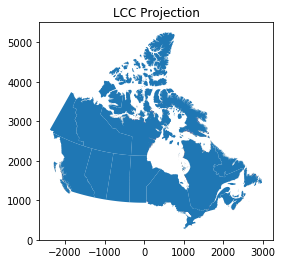

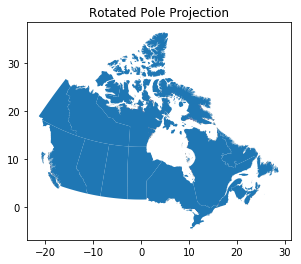

In [260]:
# canada.filter(canada.x)
# canada.intersect(area_of_interest).plot()
dir(canada)
# canada = canada.intersection(area_of_interest).boundary
canada.plot()
plt.title("LCC Projection")
plt.savefig('lcc_projection')
canadar.plot()
plt.title("Rotated Pole Projection")
plt.savefig('rotated_pole_projection')

In [224]:
canadar

0    MULTIPOLYGON (((156.52745 -37.74614, 156.51978...
1    MULTIPOLYGON (((-134.82527 -27.93165, -134.808...
2    MULTIPOLYGON (((64.10198 -73.18202, 64.12901 -...
3    MULTIPOLYGON (((-110.78621 -7.06921, -110.7929...
4    MULTIPOLYGON (((-122.69705 22.10683, -122.6906...
5    MULTIPOLYGON (((25.45950 -47.38429, 25.52364 -...
6    MULTIPOLYGON (((178.07529 54.57803, 178.08015 ...
7    MULTIPOLYGON (((-84.52015 49.09370, -84.49289 ...
8    MULTIPOLYGON (((29.81430 46.78322, 29.82023 46...
9    POLYGON ((94.74192 5.14857, 94.73513 5.15481, ...
Name: geometry, dtype: geometry

In [264]:
# points = [point for polygon in canadar for point in polygon.exterior.coords[:-1]]
# for polygon in canadar:
#     print(polygon)
from shapely.geometry import MultiPolygon, Polygon
pts = []
for poly in canadar:
    print(isinstance(poly, MultiPolygon), type(poly))
    if isinstance(poly, MultiPolygon):
        for p in poly[0::3]:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

        


True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
False <class 'shapely.geometry.polygon.Polygon'>
False <class 'shapely.geometry.polygon.Polygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>
True <class 'shapely.geometry.multipolygon.MultiPolygon'>


In [265]:
# X


In [ ]:
import plotly.graph_objects as go
X, Y = zip(*pts)
data=[dict(type='scatter',
          x=X,
          y=Y,
          mode='lines',
          line=dict(width=0.5, color='blue'),
          )]
axis_style=dict(showline=False, 
                mirror=False, 
                showgrid=False, 
                zeroline=False,
                ticks='',
                showticklabels=False)
layout=dict(title='Canada regions',
            width=700, height=700, 
            autosize=False,
            xaxis=axis_style,
            yaxis=axis_style,
            hovermode='closest')
fig=dict(data=data, layout=layout)
# py.iplot(fig, filename='France-map2d')

# fig = go.Figure(go.Scatter(x=X, y=Y, fill="toself"))
plotly.offline.plot(fig, filename='canada.html')




In [229]:
tp = {
    'northern': {
        'x1': -20,
        'y1': 0,
        'x2': -20,
        'y2': 25.5,
        'x3': -20,
        'y3': 10,
    },
    'eastern': {
        'x1': 23,
        'y1': 0,
        'x2': 5,
        'y2': 12,
        'x3': 23,
        'y3': 0,
    },
    'western': {
        'x1': -5,
        'y1': 0,
        'x2': -20,
        'y2': 14,
        'x3': -5,
        'y3': 4,
    },
}
key = 'northern'
text = tp[key]

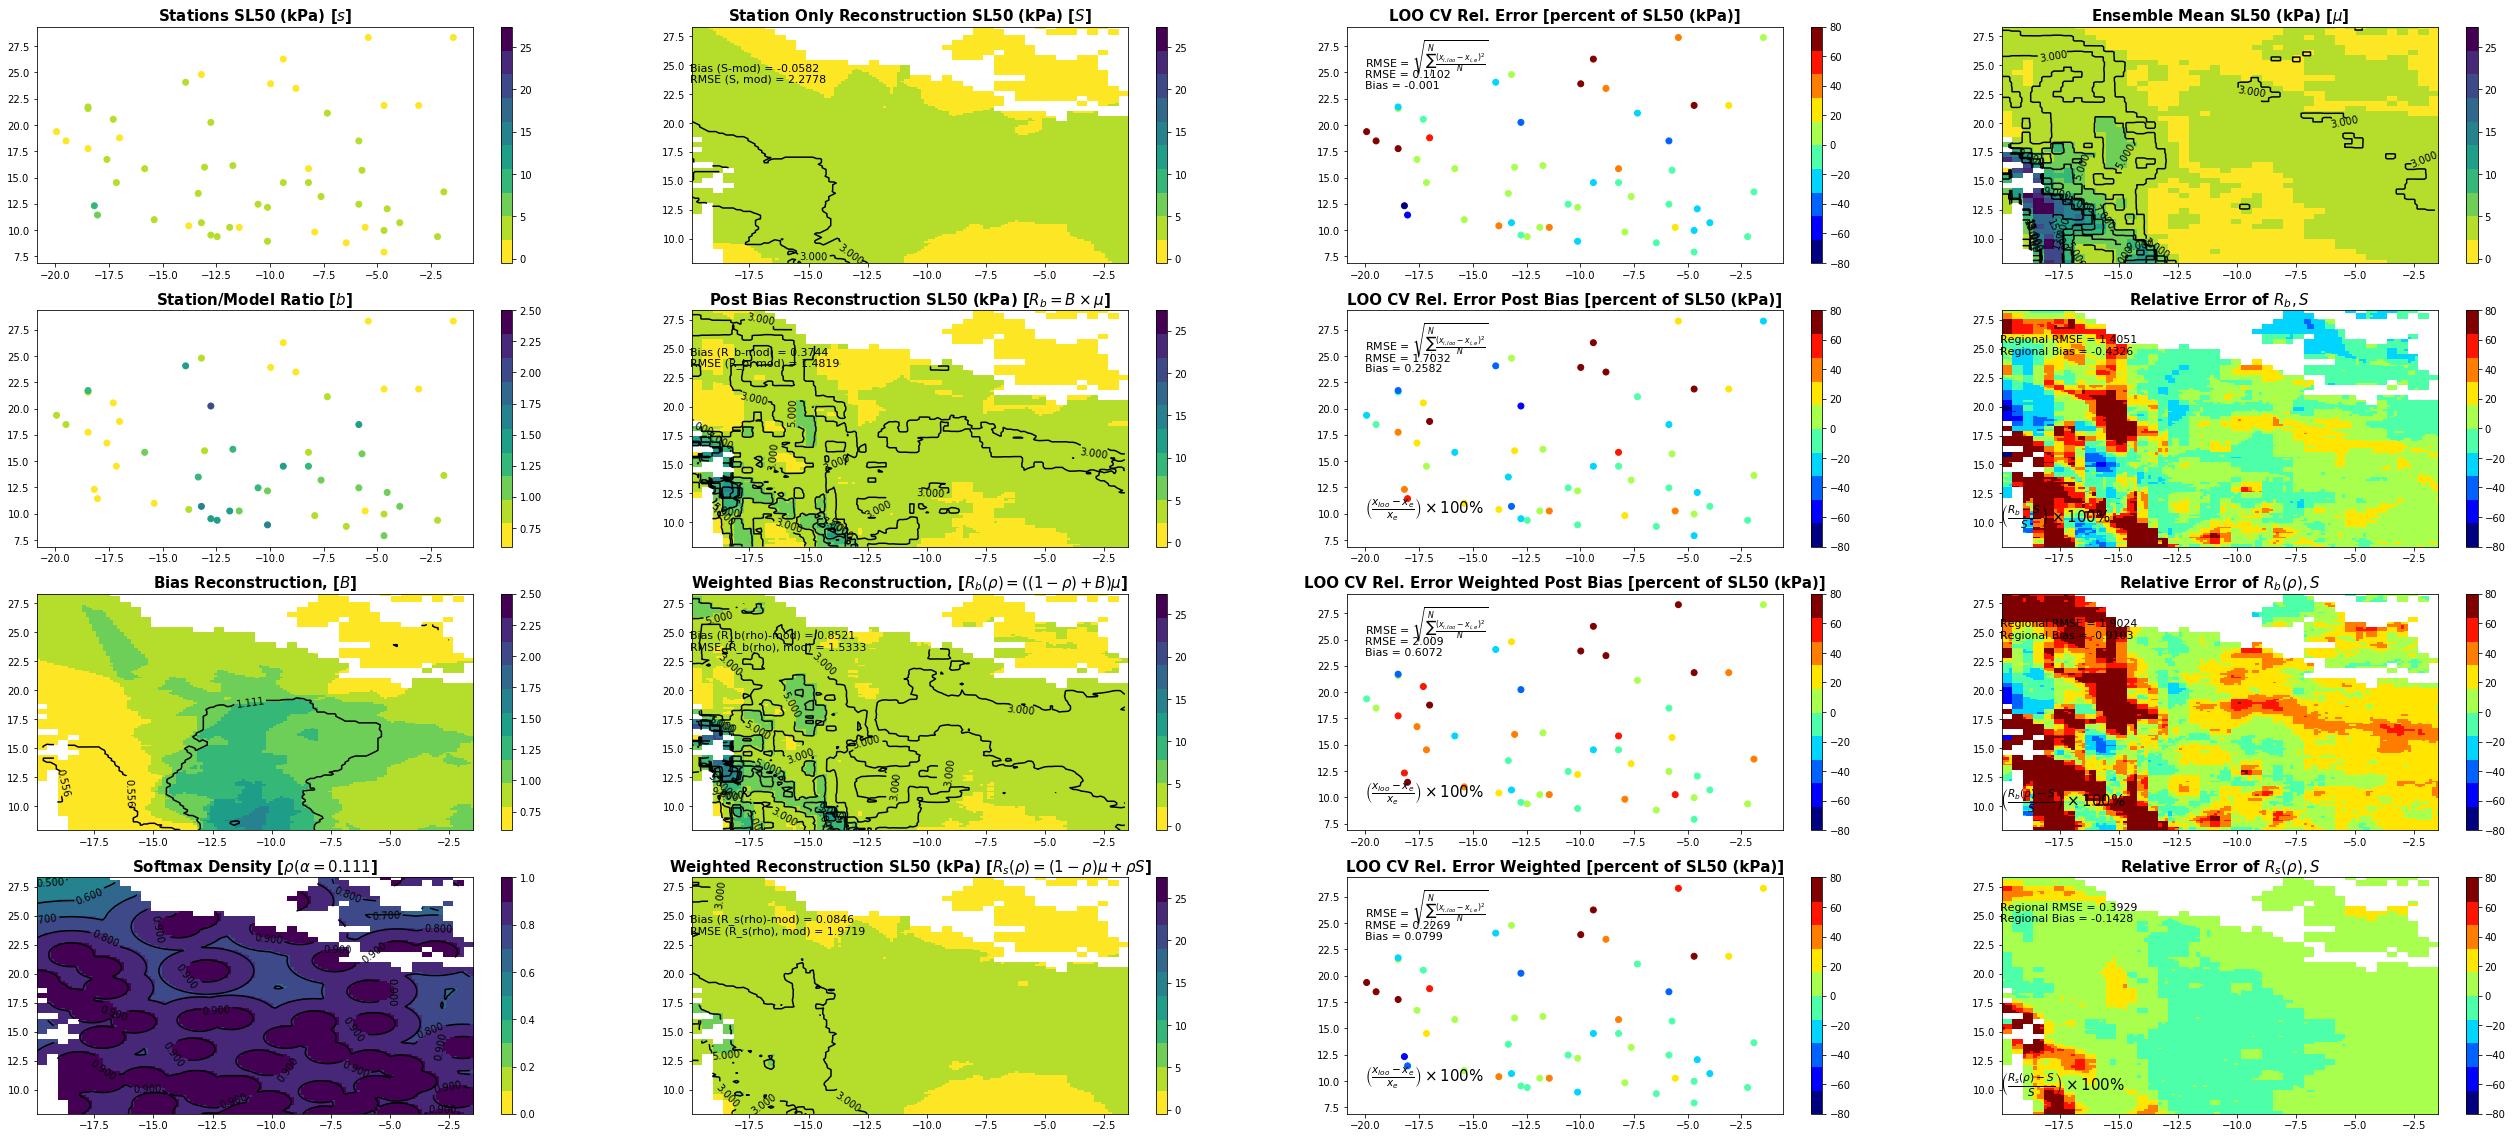

In [230]:
fig, ax = plt.subplots(4, 4, figsize=(45, 20))
zmin,zmax = -.5, np.amax(mean[region])
bmin, bmax = .6, 2.5
c = plt.cm.get_cmap("viridis_r", 10)
errorc = plt.cm.get_cmap("jet", 10)
extent=[dfc.rlon.min(), dfc.rlon.max(), dfc.rlat.min(), dfc.rlat.max()]
clevels = np.linspace(1, 15, 8)

# Tile y, x

# Tile 0, 0
stations_only = ax[0, 0].scatter(dfc.rlon, dfc.rlat, c = dfc[station_dv], cmap=c,  vmin=zmin, vmax=zmax)
ax[0, 0].set_title('Stations SL50 (kPa) [$s$]', fontsize=15, weight='bold') 
ax[0, 0].text(text['x1'], text['y1'], f'count pre match: {df[region_cond_df].shape[0]}', fontsize=15)
ax[0, 0].text(text['x1'], text['y1']-1, f'count post match: {dfc.shape[0]}', fontsize=15)
plt.colorbar(stations_only, ax=ax[0,0])
# canada.plot(ax=ax[0,0], color='black')

# Tile 0, 1
S_plot = ax[0, 1].imshow(regionalize(S), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[0, 1].set_title('Station Only Reconstruction SL50 (kPa) [$S$]', fontsize=15, weight='bold') 
S_plot_ct = ax[0, 1].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(S), 
    colors = ['black'], 
    levels = clevels)
ax[0, 1].clabel(S_plot_ct)
ax[0, 1].text(text['x2'], text['y2']-1, f'Bias (S-mod) = {round(rmse[f"bias_S_mod"], 4)}', fontsize=11)
ax[0, 1].text(text['x2'], text['y2']-2, f'RMSE (S, mod) = {round(rmse[f"rmse_S_mod"], 4)}', fontsize=11)
plt.colorbar(S_plot, ax=ax[0, 1])

# Tile 0, 2
s_loo_rmse = ax[0, 2].scatter(dfc.rlon, dfc.rlat, c = dfc.SL50_p_error, cmap=errorc, vmin=-80., vmax=80.)
ax[0, 2].set_title(r'LOO CV Rel. Error [percent of SL50 (kPa)]', fontsize=15, weight='bold')
ax[0, 2].text(text['x2'], text['y2'], r'RMSE = $\sqrt{\sum_{i}^N\frac{(x_{i, loo}- x_{i, e})^2}{N}}$', fontsize=11)
ax[0, 2].text(text['x2'], text['y2']-1, f'RMSE = {round(rmse[f"rmse_loo_s_S_at_stations"], 4)}', fontsize=11)
ax[0, 2].text(text['x2'], text['y2']-2, f'Bias = {round(rmse[f"mae_loo_s_S_at_stations"], 4)}', fontsize=11)
ax[0, 2].text(text['x1'], text['y1'], r'$\left(\frac{x_{loo} - x_e}{x_e}\right)\times 100 \%$', fontsize=15)
plt.colorbar(s_loo_rmse, ax=ax[0, 2])

# Tile 0, 3
ens_mean = ax[0, 3].imshow(regionalize(mean), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[0, 3].set_title(r'Ensemble Mean SL50 (kPa) [$\mu$]', fontsize=15, weight='bold') 
mean_ct = ax[0, 3].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(mean), 
    colors = ['black'], 
    levels = clevels)
ax[0, 3].clabel(mean_ct)
plt.colorbar(ens_mean, ax=ax[0, 3])


# Tile 1, 0
stations_only_b = ax[1, 0].scatter(dfc.rlon, dfc.rlat, c = dfc.ratio, cmap=c, vmin=bmin, vmax=bmax)
ax[1, 0].set_title('Station/Model Ratio [$b$]', fontsize=15, weight='bold') 
plt.colorbar(stations_only_b, ax=ax[1, 0])

# Tile 1, 1
B_plot = ax[1, 1].imshow(regionalize(R_b), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[1, 1].set_title(r'Post Bias Reconstruction SL50 (kPa) [$R_b=B \times \mu$]', fontsize=15, weight='bold') 
B_plot_ct = ax[1, 1].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(R_b), 
    colors = ['black'], 
    levels = clevels)
ax[1, 1].clabel(B_plot_ct)
ax[1, 1].text(text['x2'], text['y2']-1, f'Bias (R_b-mod) = {round(rmse[f"bias_R_b_mod"], 4)}', fontsize=11)
ax[1, 1].text(text['x2'], text['y2']-2, f'RMSE (R_b, mod) = {round(rmse[f"rmse_R_b_mod"], 4)}', fontsize=11)
plt.colorbar(B_plot, ax=ax[1, 1])

# Tile 1, 2
stations_only = ax[1, 2].scatter(dfc.rlon, dfc.rlat, c = dfc.post_ratio_p_error, cmap=errorc, vmin=-80., vmax=80.)
ax[1, 2].set_title(r'LOO CV Rel. Error Post Bias [percent of SL50 (kPa)]', fontsize=15, weight='bold')
ax[1, 2].text(text['x2'], text['y2'], r'RMSE = $\sqrt{\sum_{i}^N\frac{(x_{i, loo}- x_{i, e})^2}{N}}$', fontsize=11)
ax[1, 2].text(text['x2'], text['y2']-1, f'RMSE = {round(rmse[f"rmse_loo_b_post_at_stations"], 4)}', fontsize=11)
ax[1, 2].text(text['x2'], text['y2']-2, f'Bias = {round(rmse[f"mae_loo_b_post_at_stations"], 4)}', fontsize=11)
ax[1, 2].text(text['x3'], text['y3'], r'$\left(\frac{x_{loo} - x_e}{x_e}\right)\times 100 \%$', fontsize=15)
plt.colorbar(stations_only, ax=ax[1, 2])

# Tile 1, 3
stations_only_post_bias = ax[1, 3].imshow(regionalize(pe(R_b, S)), origin='lower', aspect='auto', extent=extent, cmap=errorc, vmin=-80., vmax=80.)
ax[1, 3].set_title('Relative Error of $R_b, S$ ', fontsize=15, weight='bold') 
ax[1, 3].text(text['x3'], text['y3'], r'$\left(\frac{R_b - S}{S}\right)\times 100 \%$', fontsize=15)
ax[1, 3].text(text['x2'], text['y2'], f'Regional RMSE = {round(rmse[f"rmse_R_b_S_in_region"], 4)}', fontsize=11)
ax[1, 3].text(text['x2'], text['y2']-1, f'Regional Bias = {round(rmse[f"mae_R_b_S_in_region"], 4)}', fontsize=11)
plt.colorbar(stations_only_post_bias, ax=ax[1, 3])

# Tile 2, 0
stations_only_post_bias = ax[2, 0].imshow(regionalize(B), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=bmin, vmax=bmax)
ax[2, 0].set_title('Bias Reconstruction, [$B$]', fontsize=15, weight='bold') 
ct_S_only_ps = ax[2, 0].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(B), 
    colors = ['black'], 
    levels = np.linspace(0, 5, 10))
ax[2, 0].clabel(ct_S_only_ps)
plt.colorbar(stations_only_post_bias, ax=ax[2, 0])


# Tile 2, 1
r_b_rho_plot = ax[2, 1].imshow(regionalize(R_b_rho), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[2, 1].set_title(r'Weighted Bias Reconstruction, [$R_b(\rho) = \left((1-\rho)+B\right)\mu$]', fontsize=15, weight='bold')
r_b_rho_plot_ct = ax[2, 1].contour(
    regionalize(rlon), 
    regionalize(rlat),
    regionalize(R_b_rho),
    colors = ['black'],
    levels = clevels
)
ax[2, 1].clabel(r_b_rho_plot_ct)
ax[2, 1].text(text['x2'], text['y2']-1, f'Bias (R_b(rho)-mod) = {round(rmse[f"bias_R_b_rho_mod"], 4)}', fontsize=11)
ax[2, 1].text(text['x2'], text['y2']-2, f'RMSE (R_b(rho), mod) = {round(rmse[f"rmse_R_b_rho_mod"], 4)}', fontsize=11)
plt.colorbar(r_b_rho_plot, ax=ax[2, 1])

# Tile 2, 2
stations_only = ax[2, 2].scatter(dfc.rlon, dfc.rlat, c = dfc.post_ratio_weighted_p_error, cmap=errorc, vmin=-80., vmax=80.)
ax[2, 2].set_title(r'LOO CV Rel. Error Weighted Post Bias [percent of SL50 (kPa)]', fontsize=15, weight='bold')
ax[2, 2].text(text['x2'], text['y2'], r'RMSE = $\sqrt{\sum_{i}^N\frac{(x_{i, loo}- x_{i, e})^2}{N}}$', fontsize=11)
ax[2, 2].text(text['x2'], text['y2']-1, f'RMSE = {round(rmse[f"rmse_loo_b_rho_post_S_at_stations"], 4)}', fontsize=11)
ax[2, 2].text(text['x2'], text['y2']-2, f'Bias = {round(rmse[f"mae_loo_b_rho_post_S_at_stations"], 4)}', fontsize=11)
ax[2, 2].text(text['x3'], text['y3'], r'$\left(\frac{x_{loo} - x_e}{x_e}\right)\times 100 \%$', fontsize=15)
plt.colorbar(stations_only, ax=ax[2, 2])

# Tile 3, 2
stations_only_post_bias = ax[2, 3].imshow(regionalize(pe(R_b_rho, S)), origin='lower', aspect='auto', extent=extent, cmap=errorc, vmin=-80., vmax=80.)
ax[2, 3].set_title(r'Relative Error of $R_b(\rho), S$', fontsize=15, weight='bold')
ax[2, 3].text(text['x3'], text['y3'], r'$\left(\frac{R_b(\rho) - S}{S}\right)\times 100 \%$', fontsize=15)
ax[2, 3].text(text['x2'], text['y2'], f'Regional RMSE = {round(rmse[f"rmse_R_b_rho_S_in_region"], 4)}', fontsize=11)
ax[2, 3].text(text['x2'], text['y2']-1, f'Regional Bias = {round(rmse[f"mae_R_b_rho_S_in_region"], 4)}', fontsize=11)
plt.colorbar(stations_only_post_bias, ax=ax[2, 3])

# Tile 2, 0
softmax = ax[3, 0].imshow(regionalize(rho), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=0, vmax=1)
ax[3, 0].set_title(r'Softmax Density [$\rho(\alpha = {}$]'.format(round(mina, 3)), fontsize=15, weight='bold')
ct_softmax = ax[3, 0].contour(
    regionalize(rlon), 
    regionalize(rlat),
    regionalize(rho),
    colors = ['black'],
    levels = np.linspace(0, 1, 11)
)
ax[3, 0].clabel(ct_softmax)
plt.colorbar(softmax, ax=ax[3, 0])

# Tile 3, 1
stations_only_post_bias = ax[3, 1].imshow(regionalize(R_s_rho), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[3, 1].set_title(r'Weighted Reconstruction SL50 (kPa) [$R_s(\rho) = (1-\rho)\mu+\rho S$]', fontsize=15, weight='bold') 
ct_softmax = ax[3, 1].contour(
    regionalize(rlon), 
    regionalize(rlat),
    regionalize(R_s_rho),
    colors = ['black'],
    levels = clevels
)
ax[3, 1].clabel(ct_softmax)
ax[3, 1].text(text['x2'], text['y2']-1, f'Bias (R_s(rho)-mod) = {round(rmse[f"bias_R_s_rho_mod"], 4)}', fontsize=11)
ax[3, 1].text(text['x2'], text['y2']-2, f'RMSE (R_s(rho), mod) = {round(rmse[f"rmse_R_s_rho_mod"], 4)}', fontsize=11)
plt.colorbar(stations_only_post_bias, ax=ax[3, 1])

# Tile 3, 2
stations_only = ax[3, 2].scatter(dfc.rlon, dfc.rlat, c = dfc.s_weighted_p_error, cmap=errorc, vmin=-80., vmax=80.)
ax[3, 2].set_title('LOO CV Rel. Error Weighted [percent of SL50 (kPa)]', fontsize=15, weight='bold') 
ax[3, 2].text(text['x2'], text['y2'], r'RMSE = $\sqrt{\sum_{i}^N\frac{(x_{i, loo}- x_{i, e})^2}{N}}$', fontsize=11)
ax[3, 2].text(text['x2'], text['y2']-1, f'RMSE = {round(rmse[f"rmse_loo_s_rho_S_at_stations"], 4)}', fontsize=11)
ax[3, 2].text(text['x2'], text['y2']-2, f'Bias = {round(rmse[f"mae_loo_s_rho_S_at_stations"], 4)}', fontsize=11)
ax[3, 2].text(text['x3'], text['y3'], r'$\left(\frac{x_{loo} - x_e}{x_e}\right)\times 100 \%$', fontsize=15)
plt.colorbar(stations_only, ax=ax[3, 2])

# Tile 3, 3
stations_only_post_bias = ax[3, 3].imshow(regionalize(pe(R_s_rho, S)), origin='lower', aspect='auto', extent=extent, cmap=errorc, vmin=-80., vmax=80.)
ax[3, 3].set_title(r'Relative Error of $R_s(\rho), S$', fontsize=15, weight='bold') 
ax[3, 3].text(text['x3'], text['y3'], r'$\left(\frac{R_s(\rho) - S}{S}\right)\times 100 \%$', fontsize=15)
ax[3, 3].text(text['x2'], text['y2'], f'Regional RMSE = {round(rmse[f"rmse_R_s_rho_S_in_region"], 4)}', fontsize=11)
ax[3, 3].text(text['x2'], text['y2']-1, f'Regional Bias = {round(rmse[f"mae_R_s_rho_S_in_region"], 4)}', fontsize=11)
plt.colorbar(stations_only_post_bias, ax=ax[3, 3])

# plt.savefig('tile_plot_hdd_western_KNN.pdf')
# plt.savefig('tile_plot_sl50_north.png')

In [231]:
np.sqrt(mean_squared_error(station_vals, mean[iy, ix]))

2.795185172657639

In [277]:
# 100*784/np.amax(mean[region])
# rho[region]*np.sqrt(mean_squared_error(dfc[station_dv], S[dfc.ilocy, dfc.ilocx]))
# (1-rho[region])*np.sqrt((S[region]-mean[region])**2)
# np.sqrt(mean_squared_error(dfc[station_dv], S[dfc.ilocy, dfc.ilocx]))


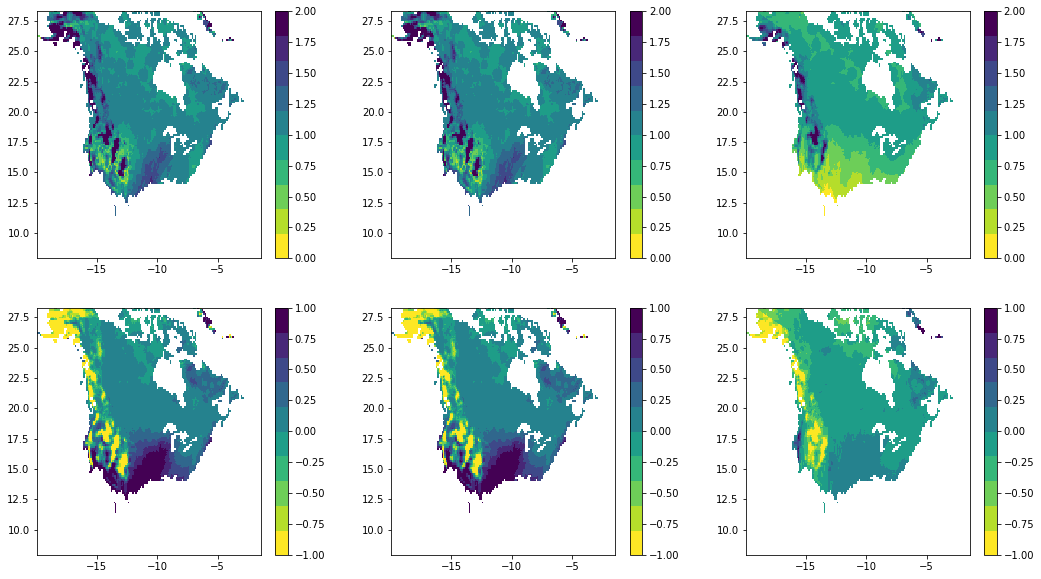

In [279]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
RMSE = S.copy()
RMSE = (1-rho)*np.sqrt((RMSE-mean)**2)+rho*np.sqrt(mean_squared_error(dfc[station_dv], RMSE[dfc.ilocy, dfc.ilocx]))
col = ax[0, 0].imshow(RMSE, origin='lower', extent=extent, cmap=c, vmin=0, vmax=2)
plt.colorbar(col, ax=ax[0,0])

RMSE = R_s.copy()
RMSE = (1-rho)*np.sqrt((RMSE-mean)**2)+rho*np.sqrt(mean_squared_error(dfc[station_dv], RMSE[dfc.ilocy, dfc.ilocx]))
col = ax[0, 1].imshow(RMSE, origin='lower', extent=extent, cmap=c, vmin=0, vmax=2)
plt.colorbar(col, ax=ax[0,1])

RMSE = R_b.copy()
RMSE = (1-rho)*np.sqrt((RMSE-mean)**2)+rho*np.sqrt(mean_squared_error(dfc[station_dv], RMSE[dfc.ilocy, dfc.ilocx]))
col = ax[0, 2].imshow(RMSE, origin='lower', extent=extent, cmap=c, vmin=0, vmax=2)
plt.colorbar(col, ax=ax[0,2])

RMSE = S.copy()
RMSE = (1-rho)*(RMSE-mean)+rho*mean_a_error(dfc[station_dv], RMSE[dfc.ilocy, dfc.ilocx])
col = ax[1, 0].imshow(RMSE, origin='lower', extent=extent, cmap=c, vmin=-1, vmax=1)
plt.colorbar(col, ax=ax[1,0])

RMSE = R_s.copy()
RMSE = (1-rho)*(RMSE-mean)+rho*mean_a_error(dfc[station_dv], RMSE[dfc.ilocy, dfc.ilocx])
col = ax[1, 1].imshow(RMSE, origin='lower', extent=extent, cmap=c, vmin=-1, vmax=1)
plt.colorbar(col, ax=ax[1,1])

RMSE = R_b.copy()
RMSE = (1-rho)*(RMSE-mean)+rho*mean_a_error(dfc[station_dv], RMSE[dfc.ilocy, dfc.ilocx])
col = ax[1, 2].imshow(RMSE, origin='lower', extent=extent, cmap=c, vmin=-1, vmax=1)
plt.colorbar(col, ax=ax[1,2])

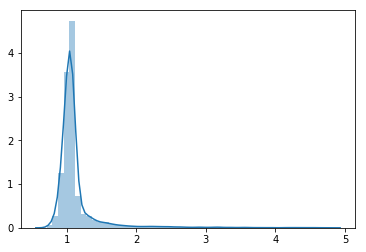

In [242]:
sns.distplot(RMSE)

In [292]:
matched_df

,ilocy,ilocx,SL50 (kPa),lat,lon,station_name,rlon,rlat
0,167,303,1.05,42.30445,-82.94445,WINDSOR RIVERSIDE,10.413335,-4.253331
1,172,305,1.50,42.99220,-82.30470,SARNIA AIRPORT,10.706668,-3.519998
2,173,311,1.50,43.00200,-81.03280,DORCHESTER,11.586668,-3.373331
3,173,314,1.60,42.86670,-80.55000,DELHI CDA,12.026668,-3.373331
4,174,311,1.80,43.03310,-81.15110,LONDON INT'L AIRPORT,11.586668,-3.226665
...,...,...,...,...,...,...,...,...
444,382,237,1.40,74.71690,-94.96940,RESOLUTE CARS,0.733333,27.280000
445,389,195,1.20,76.23330,-119.33300,MOULD BAY A,-5.426667,28.306667
446,389,222,1.60,78.78330,-103.53300,ISACHSEN,-1.466667,28.306667
447,389,248,0.90,79.98330,-85.93330,EUREKA A,2.346667,28.306667


In [365]:
Reconstruction = R_b.copy()

RMSE_mask = region.copy()
RMSE_mask[matched_df.ilocy, matched_df.ilocx] = False
RSSME = mean.copy()
b_M = (Reconstruction[RMSE_mask] - mean[RMSE_mask])
RSSME[RMSE_mask] = (1-rho[RMSE_mask])*b_M
RSSME[matched_df.ilocy, matched_df.ilocx] = (Reconstruction[matched_df.ilocy, matched_df.ilocx] - matched_df[station_dv])

print(np.sqrt(np.sum((Reconstruction[RMSE_mask] - mean[RMSE_mask])/np.sum(RMSE_mask))**2+np.sum((Reconstruction[matched_df.ilocy, matched_df.ilocx] - matched_df[station_dv])/matched_df[station_dv].size)**2))


0.7904227428973001


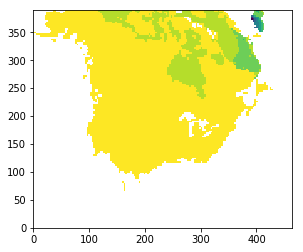

In [348]:
plt.imshow(RSSME, cmap=c, vmin=0, vmax=np.nanmax(RSSME), origin='lower')